In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model

In [2]:
def get_basket(*basket): # The collection of Pandas DataFrames from csv-files. The data has been downloaded from the Metatrader 
    """
    This function prepares and aligns data with dates and daily close prices for transmitted trading instruments.
    Finds the regression coefficients (dependent variable is the first variable in the * basket collection, other variables
    in the collection are independent) using a multiple regression model. Builds a basket, that is, difference:
    Y - k1 * X1 - k2 * X2 - ... - kn * Xn. The resulting time series is checked for stationarity by the Dickey-Fuller test. 
    Function returns: start and end date of the basket chart, regression coefficients, p-value and basket chart.
    """
    i = 0
    while i < len(basket):
        basket[i].drop(['Time', 'Open', 'High', 'Low', 'Volume'], axis = 1, inplace = True)        
        basket[i]['Date'] = pd.to_datetime(basket[i]['Date'])
        i = i + 1
        
    # Frames start date alignment----------------------------------------------------
    start_date = basket[0]['Date'][0]
    for df in basket:
        if df['Date'][0] > start_date:
            start_date = df['Date'][0]
    print(start_date)       
           
    for df in basket:
        if df['Date'][0] != start_date:
            index = df.loc[df['Date'] == start_date].index[0]
            df.drop(df.index[range(index)], inplace = True)
            df.reset_index(drop=True, inplace = True)
            
    # Frames end date alignment------------------------------------------------
    end_date = basket[0]['Date'][len(basket[0]['Date'])-1]
    for df in basket:
        if df['Date'][len(df['Date'])-1] < end_date:
            end_date = df['Date'][len(df['Date'])-1]
    print(end_date)        
        
    for df in basket:
        if df['Date'][len(df['Date'])-1] != end_date:
            index = df.loc[df['Date'] == end_date].index[0]
            df.drop(df.index[range(index+1, len(df['Date']))], inplace = True)
            df.reset_index(drop=True, inplace = True)
    
    
    # Date alignment of all frames---------------------------------------------------    
    newDF = pd.date_range(start = start_date, end = end_date)
    maska = pd.DataFrame(data = newDF, columns = ['Date'])
    date = maska['Date'].tolist()

    basket_date = [0] * len(basket)
    basket_close = [0] * len(basket)
    for i in range(len(basket)):
        basket_date[i] = basket[i]['Date'].tolist()
        basket_close[i] = basket[i]['Close'].tolist()
    
    basket_d_c = basket_date + basket_close
    basket_list = [[0] * len(date) for i in range(len(basket_d_c))]    
    for i in range(len(basket)):
        for j in range(len(date)):
            if date[j] in basket_d_c[i]:
                basket_list[i][j] = date[j]
                basket_list[i+len(basket)][j] = basket_d_c[i+len(basket)][basket_d_c[i].index(date[j])]
            else:
                basket_list[i][j] = np.nan
                basket_list[i+len(basket)][j] = np.nan
    
    columns = [0] * len(basket_list)
    for i in range(len(basket)):
        columns[i] = 'Date_' + str(i)
        columns[i+len(basket)] = 'Close_' + str(i)
    
    
    basket_frame = pd.DataFrame()
    for i in range(len(basket_list)):
        basket_frame[str(i)] = basket_list[i]
    
    
    basket_frame.columns = columns
    basket_frame.dropna(inplace = True)
    basket_frame.reset_index(drop=True, inplace = True)
    basket_frame.drop(basket_frame.columns[[i for i in range(len(basket))]], axis = 1, inplace = True)
    
    # Get basket----------------------------------------------------------------------
    regr = linear_model.LinearRegression()
    x = basket_frame.iloc[range(len(basket_frame)), [i for i in range(1, len(basket))]]
    y = basket_frame.iloc[range(len(basket_frame)), 0]
    regr.fit(x, y)
    print ('Coefficients: ', regr.coef_)
    
    basket_frame['Basket'] = basket_frame['Close_0'] - regr.coef_[0] * basket_frame['Close_1']
    if len(basket) > 2:
        for i in range(2, len(basket)):
            basket_frame['Basket'] = basket_frame['Basket'] - regr.coef_[i-1] * basket_frame['Close_' + str(i)]            
    
    from statsmodels.tsa.stattools import adfuller
    X = basket_frame['Basket']
    result = adfuller(X)    
    print('p-value: ', result[1])
    
    # Chart---------------------------------------------------------------------------
    import matplotlib.pyplot as plt
    %matplotlib inline
    y = basket_frame['Basket']
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.axhline(y=(np.mean(y) + 2*np.std(y)), color='r', linestyle='--');
    plt.axhline(y=(np.mean(y) - 2*np.std(y)), color='r', linestyle='--');
    
    return plt.plot(y) 


2011-03-03 00:00:00
2020-07-03 00:00:00
Coefficients:  [-6.77049555e-01 -4.73654383e-05 -1.31765891e-03]
p-value:  0.0011893507808371695


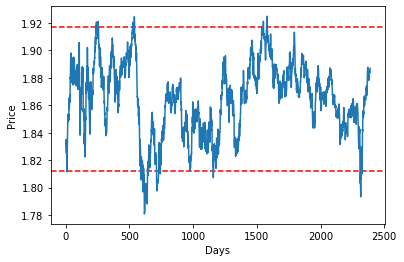

In [4]:
column_names = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
HO = pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/HO1440.csv', header = None, names = column_names)
BRN = pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/BRN1440.csv', header = None, names = column_names)
ES = pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/ES1440.csv', header = None, names = column_names)
CL = pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/CL1440.csv', header = None, names = column_names)
AUD = pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/AUDUSD1440.csv', header = None, names = column_names)
GBP = pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/GBPUSD1440.csv', header = None, names = column_names)
NQ = pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/NQ1440.csv', header = None, names = column_names)
CAD = pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/USDCAD1440.csv', header = None, names = column_names)
USDX = pd.read_csv(r'https://raw.githubusercontent.com/gelono/github-first/master/USDX1440.csv', header = None, names = column_names)

get_basket(AUD, CAD, ES, USDX)